<a href="https://colab.research.google.com/github/JoeyAviles89z/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/JoeyAviles_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [0]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [0]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
df.dtypes

Burrito                   object
Date              datetime64[ns]
Yelp                     float64
Google                   float64
Chips                     object
Cost                     float64
Hunger                   float64
Mass (g)                 float64
Density (g/mL)           float64
Length                   float64
Circum                   float64
Volume                   float64
Tortilla                 float64
Temp                     float64
Meat                     float64
Fillings                 float64
Meat:filling             float64
Uniformity               float64
Salsa                    float64
Synergy                  float64
Wrap                     float64
Unreliable                object
NonSD                     object
Beef                      object
Pico                      object
Guac                      object
Cheese                    object
Fries                     object
Sour cream                object
Pork                      object
Chicken   

##**Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.**

In [0]:
df_sub = df.copy()

In [0]:
cutoff = pd.to_datetime('01/01/2017')
cutoff2 = pd.to_datetime('01/01/2018')
train = df_sub[df_sub.Date < cutoff]
val = df_sub[df_sub.Date < cutoff2]
test = df_sub[df_sub.Date >= cutoff2]

In [0]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, random_state=42) #random_state will give us the same rows

train.shape, val.shape

((223, 59), (75, 59))

In [0]:
train

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
227,California,2016-09-11,NaN,NaN,NaN,5.79,4.00,NaN,NaN,NaN,NaN,NaN,4.0,3.0,4.0,2.5,3.5,4.0,2.0,2.5,5.0,NaN,NaN,x,NaN,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
79,Other,2016-04-27,NaN,NaN,NaN,6.39,3.00,NaN,NaN,23.0,22.5,0.93,4.0,3.0,2.5,3.5,3.0,3.0,3.5,4.0,3.5,NaN,NaN,X,NaN,X,X,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
66,California,2016-04-15,4.5,4.4,x,6.25,4.00,NaN,NaN,NaN,NaN,NaN,4.5,4.5,2.5,3.5,3.5,3.5,3.0,4.0,5.0,NaN,NaN,x,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
298,California,2016-12-10,3.5,3.7,NaN,7.75,4.00,NaN,NaN,20.0,21.0,0.70,3.5,2.5,3.0,3.3,1.4,2.3,2.2,3.3,4.5,NaN,NaN,X,X,NaN,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
283,Asada,2016-11-16,NaN,NaN,NaN,6.75,3.00,NaN,NaN,18.0,21.5,0.66,4.5,4.7,4.5,3.5,4.0,4.5,4.5,3.5,5.0,NaN,NaN,x,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,California,2016-08-27,4.0,4.1,x,5.99,4.00,NaN,NaN,18.5,21.0,0.65,4.0,4.5,2.5,2.5,2.5,1.5,3.0,4.0,5.0,NaN,NaN,X,NaN,NaN,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
71,Other,2016-04-15,NaN,NaN,NaN,6.50,2.50,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.5,4.0,4.0,3.0,NaN,4.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
107,Other,2016-05-20,NaN,NaN,NaN,6.50,4.00,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,4.0,5.0,4.0,4.0,5.0,4.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
273,California,2016-11-02,NaN,NaN,NaN,6.39,4.25,NaN,NaN,22.0,22.0,0.85,2.0,4.0,3.7,2.0,4.0,4.5,4.5,2.7,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [0]:
val

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
160,California,2016-06-24,NaN,NaN,NaN,6.25,4.5,NaN,NaN,22.5,22.0,0.87,4.0,4.0,4.5,4.0,4.0,3.5,4.0,4.0,4.5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
267,Other,2016-10-27,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,3.0,2.0,2.0,NaN,1.0,5.0,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
257,Other,2016-10-17,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.5,4.2,4.7,4.4,4.0,4.9,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
9,Asada,2016-02-06,4.0,4.1,NaN,6.25,3.5,NaN,NaN,NaN,NaN,NaN,2.5,1.5,1.5,3.0,4.5,3.0,1.5,2.0,4.5,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
78,California,2016-04-27,4.5,4.4,x,6.89,3.0,NaN,NaN,25.0,22.0,0.96,3.0,2.5,3.0,2.5,2.5,2.0,3.5,3.0,4.0,NaN,NaN,X,NaN,X,x,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,Other,2016-06-01,NaN,NaN,NaN,4.87,2.5,NaN,NaN,19.5,20.5,0.65,3.5,3.0,2.5,2.4,3.5,4.5,3.0,3.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
239,California,2016-09-22,4.5,4.7,NaN,6.35,4.0,NaN,NaN,NaN,NaN,NaN,4.0,2.5,4.0,3.0,4.5,2.0,2.0,3.0,4.0,NaN,NaN,x,x,NaN,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
270,Other,2016-11-01,NaN,NaN,NaN,5.99,4.0,NaN,NaN,19.5,21.5,0.72,3.0,4.5,3.7,2.8,5.0,4.5,3.0,2.3,4.5,NaN,NaN,NaN,X,X,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
203,Surf & Turf,2016-08-30,NaN,NaN,NaN,8.25,2.0,NaN,NaN,20.0,24.5,0.96,3.5,2.0,5.0,3.5,4.0,2.5,3.5,3.0,3.5,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,False


In [0]:
test

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
77,California,2026-04-25,NaN,NaN,NaN,8.00,4.0,NaN,NaN,21.59,NaN,NaN,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
386,California,2018-01-02,NaN,NaN,NaN,7.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
387,Other,2018-01-09,4.5,3.8,NaN,4.19,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,2.0,2.0,4.0,1.0,4.0,3.0,4.0,x,NaN,NaN,NaN,NaN,x,NaN,x,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,False
388,California,2018-01-12,3.5,4.3,NaN,7.00,5.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
389,Other,2018-01-12,NaN,NaN,NaN,8.50,4.0,NaN,NaN,21.00,23.5,0.92,4.0,4.0,3.0,3.5,1.0,2.0,3.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
390,Asada,2018-04-04,NaN,NaN,NaN,7.20,3.0,NaN,NaN,24.50,22.7,1.00,4.0,5.0,4.0,3.0,3.0,3.0,4.0,3.0,4.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
391,Carnitas,2018-04-09,NaN,NaN,NaN,5.99,3.0,NaN,NaN,20.00,23.0,0.84,3.5,5.0,4.3,3.5,5.0,4.0,3.0,3.8,2.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
392,Carnitas,2018-04-09,NaN,NaN,NaN,5.99,3.5,NaN,NaN,17.50,24.0,0.80,4.0,4.5,5.0,4.5,5.0,4.0,4.0,4.5,4.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
393,Carnitas,2018-04-09,NaN,NaN,NaN,5.99,2.0,NaN,NaN,19.00,24.5,0.91,2.0,3.5,4.5,4.0,4.0,2.0,3.0,4.0,2.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
394,California,2018-04-14,NaN,NaN,NaN,8.99,4.0,NaN,NaN,25.00,23.0,1.05,4.5,4.5,4.0,4.0,3.0,4.0,3.5,4.0,3.0,NaN,NaN,x,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
test.shape

(38, 59)

 Begin with baselines for classification.

In [0]:
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.578475
True     0.421525
Name: Great, dtype: float64

57% didn't think it was great and 42% thought it was great

Guessing the majority class for every prediction

In [0]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
print(majority_class)
print(y_pred)

False
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,

What is the baseline accuracy if we guessed the majority class for every prediction?

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
#training accuracy of majority class baseline = frequency of majority class (base rate)
accuracy_score(y_train, y_pred)

0.57847533632287

In [0]:
#Validation accuracy of majority class baseline = usually similar to Train accuracy
y_val = val[target]
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.6266666666666667

In [0]:
train.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,54.000000,54.000000,220.000000,222.000000,0.0,0.0,133.000000,132.000000,132.000000,223.000000,213.000000,215.000000,222.000000,217.000000,221.000000,210.000000,221.000000,221.000000,0.0
mean,3.864815,4.133333,6.902409,3.464640,NaN,NaN,19.772782,21.947727,0.762727,3.485650,3.763850,3.586744,3.552027,3.530553,3.391855,3.340238,3.584615,3.951131,NaN
std,0.481804,0.327368,1.261173,0.857374,NaN,NaN,2.117857,1.682528,0.140289,0.790638,0.956042,0.811828,0.835176,1.012019,1.082601,1.003910,0.882926,1.184775,NaN
min,2.500000,3.300000,2.990000,0.500000,NaN,NaN,15.000000,17.000000,0.400000,1.400000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,NaN,NaN,18.500000,20.950000,0.650000,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.562500,3.000000,3.500000,NaN
50%,4.000000,4.150000,6.850000,3.500000,NaN,NaN,19.500000,22.000000,0.750000,3.500000,4.000000,3.500000,3.500000,4.000000,3.500000,3.500000,4.000000,4.000000,NaN
75%,4.000000,4.375000,7.500000,4.000000,NaN,NaN,21.000000,23.000000,0.870000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,4.900000,11.950000,5.000000,NaN,NaN,26.000000,26.500000,1.240000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [0]:
train.describe(exclude='number').T

,count,unique,top,freq,first,last
Burrito,223,5,Other,86,NaT,NaT
Date,223,100,2016-08-30 00:00:00,22,2016-01-18,2016-12-15
Chips,18,2,x,15,NaT,NaT
Unreliable,20,1,x,20,NaT,NaT
NonSD,5,2,x,3,NaT,NaT
Beef,120,2,x,92,NaT,NaT
Pico,102,2,x,80,NaT,NaT
Guac,102,2,x,72,NaT,NaT
Cheese,110,2,x,88,NaT,NaT
Fries,86,2,x,70,NaT,NaT


Date has a high cardinality of 100

In [0]:
features = ['Yelp', 'Google', 'Cost', 'Hunger', 'Length', 'Circum', 'Volume', 'Tortilla', 'Wrap', 'Burrito' ]
target = 'Great'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((223, 10), (223,), (75, 10), (75,))

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [0]:
X_train.head()

,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Wrap,Burrito
227,NaN,NaN,5.79,4.0,NaN,NaN,NaN,4.0,5.0,California
79,NaN,NaN,6.39,3.0,23.0,22.5,0.93,4.0,3.5,Other
66,4.5,4.4,6.25,4.0,NaN,NaN,NaN,4.5,5.0,California
298,3.5,3.7,7.75,4.0,20.0,21.0,0.70,3.5,4.5,California
283,NaN,NaN,6.75,3.0,18.0,21.5,0.66,4.5,5.0,Asada


In [0]:
X_val.head()

,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Wrap,Burrito
160,NaN,NaN,6.25,4.5,22.5,22.0,0.87,4.0,4.5,California
267,NaN,NaN,NaN,3.0,NaN,NaN,NaN,5.0,5.0,Other
257,NaN,NaN,NaN,3.5,NaN,NaN,NaN,4.0,5.0,Other
9,4.0,4.1,6.25,3.5,NaN,NaN,NaN,2.5,4.5,Asada
78,4.5,4.4,6.89,3.0,25.0,22.0,0.96,3.0,4.0,California


In [0]:
encoder = ce.OneHotEncoder(use_cat_names=True) #encoder does work with strings to change them
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [0]:
X_train_encoded.head()

,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Wrap,Burrito_California,Burrito_Other,Burrito_Asada,Burrito_Carnitas,Burrito_Surf & Turf
227,NaN,NaN,5.79,4.0,NaN,NaN,NaN,4.0,5.0,1,0,0,0,0
79,NaN,NaN,6.39,3.0,23.0,22.5,0.93,4.0,3.5,0,1,0,0,0
66,4.5,4.4,6.25,4.0,NaN,NaN,NaN,4.5,5.0,1,0,0,0,0
298,3.5,3.7,7.75,4.0,20.0,21.0,0.70,3.5,4.5,1,0,0,0,0
283,NaN,NaN,6.75,3.0,18.0,21.5,0.66,4.5,5.0,0,0,1,0,0


In [0]:
X_val_encoded.head()

,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Wrap,Burrito_California,Burrito_Other,Burrito_Asada,Burrito_Carnitas,Burrito_Surf & Turf
160,NaN,NaN,6.25,4.5,22.5,22.0,0.87,4.0,4.5,1,0,0,0,0
267,NaN,NaN,NaN,3.0,NaN,NaN,NaN,5.0,5.0,0,1,0,0,0
257,NaN,NaN,NaN,3.5,NaN,NaN,NaN,4.0,5.0,0,1,0,0,0
9,4.0,4.1,6.25,3.5,NaN,NaN,NaN,2.5,4.5,0,0,1,0,0
78,4.5,4.4,6.89,3.0,25.0,22.0,0.96,3.0,4.0,1,0,0,0,0


In [0]:
#Fill in the NaN with the mean using SimpleImputer, (SimpleImputer does not work with strings(objects))
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

In [0]:
X_train_imputed.head()

AttributeError: ignored

X_train_imputed.head() will give you an error because its not a dataframe its a numpy.array.

In [0]:
X_train_imputed[:5]

array([[ 3.86481481,  4.13333333,  5.79      ,  4.        , 19.77278195,
        21.94772727,  0.76272727,  4.        ,  5.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 3.86481481,  4.13333333,  6.39      ,  3.        , 23.        ,
        22.5       ,  0.93      ,  4.        ,  3.5       ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ],
       [ 4.5       ,  4.4       ,  6.25      ,  4.        , 19.77278195,
        21.94772727,  0.76272727,  4.5       ,  5.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 3.5       ,  3.7       ,  7.75      ,  4.        , 20.        ,
        21.        ,  0.7       ,  3.5       ,  4.5       ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 3.86481481,  4.13333333,  6.75      ,  3.        , 18.        ,
        21.5       ,  0.66      ,  4.5       ,  5.        ,  0.        ,
         0.        ,  1.  

In [0]:
#To change it into a dataframe
pd.DataFrame(X_train_imputed, columns=X_train_encoded.columns)

,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Wrap,Burrito_California,Burrito_Other,Burrito_Asada,Burrito_Carnitas,Burrito_Surf & Turf
0,3.864815,4.133333,5.79,4.00,19.772782,21.947727,0.762727,4.0,5.0,1.0,0.0,0.0,0.0,0.0
1,3.864815,4.133333,6.39,3.00,23.000000,22.500000,0.930000,4.0,3.5,0.0,1.0,0.0,0.0,0.0
2,4.500000,4.400000,6.25,4.00,19.772782,21.947727,0.762727,4.5,5.0,1.0,0.0,0.0,0.0,0.0
3,3.500000,3.700000,7.75,4.00,20.000000,21.000000,0.700000,3.5,4.5,1.0,0.0,0.0,0.0,0.0
4,3.864815,4.133333,6.75,3.00,18.000000,21.500000,0.660000,4.5,5.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,4.000000,4.100000,5.99,4.00,18.500000,21.000000,0.650000,4.0,5.0,1.0,0.0,0.0,0.0,0.0
219,3.864815,4.133333,6.50,2.50,19.772782,21.947727,0.762727,3.0,1.5,0.0,1.0,0.0,0.0,0.0
220,3.864815,4.133333,6.50,4.00,19.772782,21.947727,0.762727,3.0,4.0,0.0,1.0,0.0,0.0,0.0
221,3.864815,4.133333,6.39,4.25,22.000000,22.000000,0.850000,2.0,5.0,1.0,0.0,0.0,0.0,0.0


In [0]:
X_val_imputed[:5]

array([[ 3.86481481,  4.13333333,  6.25      ,  4.5       , 22.5       ,
        22.        ,  0.87      ,  4.        ,  4.5       ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 3.86481481,  4.13333333,  6.90240909,  3.        , 19.77278195,
        21.94772727,  0.76272727,  5.        ,  5.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ],
       [ 3.86481481,  4.13333333,  6.90240909,  3.5       , 19.77278195,
        21.94772727,  0.76272727,  4.        ,  5.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ],
       [ 4.        ,  4.1       ,  6.25      ,  3.5       , 19.77278195,
        21.94772727,  0.76272727,  2.5       ,  4.5       ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ],
       [ 4.5       ,  4.4       ,  6.89      ,  3.        , 25.        ,
        22.        ,  0.96      ,  3.        ,  4.        ,  1.        ,
         0.        ,  0.  

In [0]:
scaler = StandardScaler() #Will allow us to compare the relative strength of coefficients, the coefficients with the highest absolute values are the most important
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [0]:
X_val_scaled[:5]

array([[ 1.89066474e-15, -5.56517058e-15, -5.22006438e-01,
         1.21304672e+00,  1.67374290e+00,  4.05349443e-02,
         9.97658530e-01,  6.52013829e-01,  4.66416303e-01,
         1.27417794e+00, -7.92298698e-01, -3.55334527e-01,
        -2.27786726e-01, -2.78019219e-01],
       [ 1.89066474e-15, -5.56517058e-15,  7.10650510e-16,
        -5.44380116e-01, -2.18036445e-15,  2.75495576e-15,
         1.03253035e-15,  1.91966059e+00,  8.91305020e-01,
        -7.84819743e-01,  1.26215025e+00, -3.55334527e-01,
        -2.27786726e-01, -2.78019219e-01],
       [ 1.89066474e-15, -5.56517058e-15,  7.10650510e-16,
         4.14288309e-02, -2.18036445e-15,  2.75495576e-15,
         1.03253035e-15,  6.52013829e-01,  8.91305020e-01,
        -7.84819743e-01,  1.26215025e+00, -3.55334527e-01,
        -2.27786726e-01, -2.78019219e-01],
       [ 5.75537207e-01, -2.08860835e-01, -5.22006438e-01,
         4.14288309e-02, -2.18036445e-15,  2.75495576e-15,
         1.03253035e-15, -1.24945632e+00,  4.

In [0]:
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.7733333333333333


##Plot coefficients:

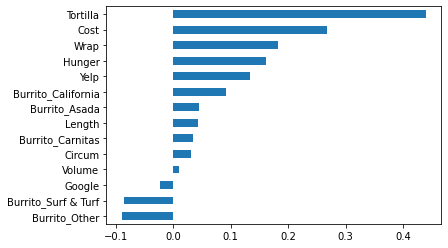

In [0]:
%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns) #The .coef_[0] is for list within a list [[]]
coefficients.sort_values().plot.barh(); #Your seeing which ones are larger and smaller, largest positive values (at the top) and largest negative value at the bottom